In [1]:
cd /home/paperspace/fastai/

/home/paperspace/fastai


In [2]:
from sklearn import model_selection
import html
import time
from fastai.text import *
#import matplotlib.pyplot as plt

In [3]:
DATAPATH=Path('/home/paperspace/data/toxic/')
PATH=Path('/home/paperspace/data/toxic_fromscratch/')
LM_PATH=Path('/home/paperspace/data/toxic_lm/')

# Preprocessing and tokenization

In [12]:
#create dfs from the csvs
trn_csv=pd.read_csv(DATAPATH/'train.csv')
test_csv=pd.read_csv(DATAPATH/'test.csv')

In [29]:
#160K training comments, 153K test comments
(np.shape(trn_csv),np.shape(test_csv))

((159571, 8), (153164, 2))

In [12]:
trn_csv.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
trn_texts=np.array(trn_csv['comment_text'])
test_texts=np.array(test_csv['comment_text'])

In [18]:
#for language model, might as well create our own train-test split
trn_texts,val_texts = model_selection.train_test_split(
    np.concatenate([trn_texts,test_texts]), test_size=0.1)

In [23]:
(np.shape(trn_texts),np.shape(val_texts))

((281461,), (31274,))

In [24]:
trn_texts[0]

'"\nI agree.  I find that claim highly dubious. -\'\'\'\'\'\'The \'45 "'

In [15]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [16]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [17]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):#this is looping through chunks of size chunksize through the df
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)#for each chunk, we get the tokens and the labels
        tok += tok_;# then append the chunk's tokens and labels to a master list of tokens and labels
        labels += labels_
    return tok, labels

In [7]:
chunksize=24000

In [8]:
#using chunksize makes it so pandas returns an iterator (instead of a df), where we can iterate through chunks of a df.
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [15]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
tok_trn, trn_labels = get_all(df_trn, 1)#tok_trn is a list of the texts. 1 is number of labels. Each item of the list is itself a list of the tokens for that text.
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
0
1


In [16]:
np.shape(tok_trn),np.shape(trn_labels)

((281461,), (281461, 1))

In [17]:
tok_trn[0][:10]

['\n',
 'xbos',
 'xfld',
 '1',
 'david',
 'hillier',
 '\n\n',
 'was',
 'david',
 'hillier']

In [18]:
' '.join(tok_trn[0])

'\n xbos xfld 1 david hillier \n\n was david hillier t_up really called up by fabio capello to the england squad tk_rep 5 ? tk_rep 5 !'

In [19]:
#save the tokenizer
np.save(PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(PATH/'tmp'/'tok_val.npy', tok_val)
tok_trn = np.load(PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(PATH/'tmp'/'tok_val.npy')

In [20]:
#the comprehension says: for each text o in tok_trn, go through and return each token p. Then Counter creates a list of token-frequency tuples.
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 863653),
 ('the', 826975),
 (',', 784683),
 ('"', 668599),
 ('to', 485505),
 ('t_up', 409797),
 ('i', 388003),
 ('of', 368867),
 ('and', 368276),
 ('a', 367615),
 ('\n', 359456),
 ('you', 351595),
 ('is', 308740),
 ('1', 289995),
 ('xbos', 281461),
 ('xfld', 281461),
 ('that', 267248),
 ('it', 249264),
 ('in', 242439),
 (':', 217626),
 ('=', 179106),
 ('for', 167023),
 ('this', 162817),
 ('-', 156535),
 ('not', 156517)]

In [21]:
max_vocab = 60000 #howard says having a vocab larger than 60K words doesn't even help more
min_freq = 2

In [22]:
#the comprehension says: sort the 60K most common tokens in the freq Counter, then return each token as long as freq>2 
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')#insert some special tokens at the top
itos.insert(0, '_unk_')

In [23]:
#the collections.defaultdict creates a dictionary that returns the default value of 0 for keys that it hasn't yet seen
#for more info check out https://docs.python.org/2/library/collections.html
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [24]:
stoi

defaultdict(<function __main__.<lambda>>,
            {'_unk_': 0,
             '_pad_': 1,
             '.': 2,
             'the': 3,
             ',': 4,
             '"': 5,
             'to': 6,
             't_up': 7,
             'i': 8,
             'of': 9,
             'and': 10,
             'a': 11,
             '\n': 12,
             'you': 13,
             'is': 14,
             '1': 15,
             'xbos': 16,
             'xfld': 17,
             'that': 18,
             'it': 19,
             'in': 20,
             ':': 21,
             '=': 22,
             'for': 23,
             'this': 24,
             '-': 25,
             'not': 26,
             'on': 27,
             ')': 28,
             '\n ': 29,
             'be': 30,
             '(': 31,
             '\n\n ': 32,
             'as': 33,
             'are': 34,
             'have': 35,
             "'s": 36,
             '?': 37,
             '!': 38,
             'do': 39,
             '\n\n': 40,
        

In [25]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])#for every sentence p in tok_trn, for every word o in p return the stoi int for that word
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [27]:
np.save(PATH/'tmp'/'trn_ids.npy', trn_lm) #save the numericalized lists
np.save(PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(PATH/'tmp'/'itos.pkl', 'wb'))#need to save the vocab! Otherwise the numericalized lists mean nothing

# Load in wikitext pretrained model

In [12]:
trn_lm = np.load(PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(PATH/'tmp'/'itos.pkl', 'rb'))
vs=len(itos)
vs,len(trn_lm)

(60002, 281461)

In [4]:
WIKIPATH=Path('/home/paperspace/data/aclImdb/')
PRE_PATH = WIKIPATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [5]:
em_sz=400

In [6]:
#using pytorch’s load function. This basically returns a dictionary containing the name of the layer and a tensor of the accompanying weights
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [7]:
enc_wgts = to_np(wgts['0.encoder.weight']) #this is wt103's embedding matrix! of size (238462, 400)
row_m = enc_wgts.mean(0)#the average embedding

In [8]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))# we need to map our itos to wt103's itos! 
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)}) #default -1 means its not in wt103's itos

In [11]:
print(itos2[:10])

['_unk_', '_pad_', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a']


In [14]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)#initialize new weights to zeros of size (vocab_size,embedding size) i.e. (60002,400)... we're creating an embedding matrix 
#for index,word in our itos dict, get r index of the word in wt103's dict. 
#r will be -1 if it doesn't exist in wt103's dict
for i,w in enumerate(itos): 
    r = stoi2[w]
#for our new embedding matrix, set the embedding at the index from our dict equal to 
#the embedding from index r from wt103's dict
    new_w[i] = enc_wgts[r] if r>=0 else row_m 

In [15]:
print(np.shape(new_w))

(60002, 400)


In [16]:
pickle.dump(new_w, open(PATH/'tmp'/'new_w.pkl', 'wb'))#save the new weights

# Language Model

In [4]:
trn_lm = np.load(PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(PATH/'tmp'/'itos.pkl', 'rb'))
new_w = pickle.load(open(PATH/'tmp'/'new_w.pkl', 'rb'))
emb_sz=np.shape(new_w)[1]
vs=len(itos)
vs,len(trn_lm)

(60002, 281461)

In [5]:
bptt=70
bs=50
nh=100
nl=3
lr=1e-3

In [6]:
print(np.shape(trn_lm),np.shape(val_lm))
print(trn_lm[0][:10]) #trn_lm is a list of lists, each w/ the token #s for a given text
print(' '.join([itos[trn_lm[0][i]] for i in range(20)]))

(281461,) (31274,)
[12, 16, 17, 15, 1267, 39518, 40, 46, 1267, 39518]

 xbos xfld 1 david hillier 

 was david hillier t_up really called up by fabio _unk_ to the england


In [7]:
#Create trn_vec by concatenating together trn_lm, leaving a 24M long list of token #s. Same thing for val_vec (2.6M)
trn_vec=np.concatenate(trn_lm)
val_vec=np.concatenate(val_lm)
(np.shape(trn_vec),np.shape(val_vec))
nwords=len(trn_vec)
val_nwords=len(val_vec)
print(nwords)

24165472


In [8]:
class rnnNet(nn.Module):
    def __init__(self):
        super(rnnNet, self).__init__()#the required Python super() function, which creates an instance of the base nn.Module class
        self.embedding = nn.Embedding(vs, emb_sz) 
        self.rnn=nn.LSTM(emb_sz, nh, nl)
        self.fc1 = nn.Linear(nh, vs)# 
        self.hidden=(self.one_hidden(), self.one_hidden())
    def forward(self, x):
        x=self.embedding(x)
        outputta,new_h = self.rnn(x, self.hidden)
        self.hidden = (Variable(new_h[0].data),Variable(new_h[1].data))#repackage!
        x= self.fc1(outputta)
        return F.log_softmax(x.view(-1,vs))
    def one_hidden(self):
        #SHOULD TRY INITIALIZING THIS TO SOMETHING MORE SENSIBLE THAN ZEROS
        return Variable(torch.zeros(nl, bs, nh).cuda(), requires_grad=False)

In [9]:
class dwb_model():
    def __init__(self,trn_dl,val_dl,module,kwargs=None):
        self.trn_dl, self.val_dl, self.module = trn_dl, val_dl, module
        self.kwargs=kwargs
        self.model=self.module().cuda()
        self.oldfilename=''
        self.howdwegethere='scratch'
        self.filename=kwargs['filename']
        self.PATH=kwargs['PATH']
        self.optimizer = optim.Adam(self.model.parameters(), kwargs['lr'])
        self.kwargs['optimizer_str']=str(self.optimizer)
    def get_clr_schedule(self,downsampler,samp_n,min_lr=.001,max_lr=.05,epochs=2,clr_cycles=1,**kwargs):
        total_its=math.ceil(samp_n*epochs/downsampler)+5
        stepsize=total_its/clr_cycles/2
        cyclelist=[]
        xlist=[]
        lrlist=[]
        for itCounter in range(0,total_its):
            cycle=np.floor(1+itCounter/(2*stepsize))
            cyclelist.append(cycle)
            x=np.abs(itCounter / stepsize - 2 * cycle + 1)
            xlist.append(x)
            lr=min_lr + (max_lr-min_lr)*np.maximum(0,(1-x))
            lrlist.append(lr)
        return lrlist
    def model_fit(self,epochs=5,filename='',**kwargs):
        clr_cycles=self.kwargs['clr_cycles']
        curr_lr=self.kwargs['lr']
        samp_n=self.kwargs['samp_n']
        bs=self.kwargs['bs']
        downsampler=samp_n/200
        if clr_cycles>0:
            self.clr_schedule=self.get_clr_schedule(downsampler,**self.kwargs)
        self.howdwegethere=self.howdwegethere+' -> '+filename
        self.generate_report(**self.kwargs)
        run_report=self.modify_report(**self.kwargs)
        starttime=time.time()
        train_loss_list=[]
        val_loss_list=[]
        for epoch in range(0, epochs):
            pbar=0#progressbar
            for batch_idx, (data, target) in enumerate(trn_dl):
                #data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                pbar+=len(data)*bs
                if clr_cycles>0:
                    self.overall_it=math.floor((pbar+epoch*samp_n)/downsampler)
                    curr_lr=self.clr_schedule[self.overall_it]
                    self.optimizer = optim.Adam(self.model.parameters(), curr_lr)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                self.optimizer.step()#this actually updates the weights!
                train_loss_list.append([epoch,pbar+epoch*samp_n,loss.data[0],curr_lr])
                if batch_idx % 200 == 0:
                    elapsed_time=time.time()-starttime
                    train_update_format_string = 'Train Epoch: {}'
                    train_update_format_string += '\tTotal_its: {:.2f}M [{:.2f}M/{:.2f}M]'
                    train_update_format_string += '\tPercdone: {:.2f}'
                    train_update_format_string += '\tLoss: {:.4f}'
                    train_update_format_string += '\tTime: {:.2f}'
                    train_update_format_string += '\tLR: {:.4f}'
                    train_update_string=train_update_format_string.format(
                            epoch,
                            (pbar + epoch * samp_n) / 1000000, pbar / 1000000, samp_n / 1000000,
                            pbar / samp_n,
                            loss.data[0],
                            elapsed_time / 60,
                            curr_lr)
                    #train_update_string='Epoch: {}\tTot_its: {:.2f}M [{:.2f}M/{:.2f}M]\tPercdone: {:.2f}\tLoss: {:.4f}\tTime: {:.2f}\tLR: {:.4f}'.format(
                    #        epoch,(pbar+epoch*samp_n)/1000000, pbar/1000000, samp_n/1000000, pbar/samp_n,
                    #                loss.data[0], elapsed_time/60, curr_lr)
                    print(train_update_string)
                    run_report.write(train_update_string+'\n')
            final_train_loss=loss.data[0]
            val_loss=torch.Tensor().cuda()
            val_acc=[]
            for batch_idx, (data, target) in enumerate(val_dl):
                data, target = Variable(data), Variable(target)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                preds = torch.max(output, dim=1)[1]
                val_loss=torch.cat((val_loss,loss.data),0)
                val_acc.append(torch.eq(preds.data,target.data).float().mean())
            val_update_string='Validation Loss: {:.4f}\tAcc: {:.4f}\tPerp: {:.4f}'.format(
                val_loss.mean(),np.mean(np.array(val_acc)),np.exp(val_loss.mean()))
            print(val_update_string)
            run_report.write(val_update_string+'\n')
            val_loss_list.append([epoch,val_loss.mean(),np.exp(val_loss.mean())])
        self.val_loss_list=val_loss_list
        self.train_loss_list=train_loss_list
        self.final_val_loss=np.mean(np.array(val_acc))
        print('The end! {:.2f} minutes'.format((time.time()-starttime)/60))
        run_report.write('final_time: '+str((time.time()-starttime)/60)+'\n')
        run_report.write('final_train_loss: '+str(final_train_loss)+'\n')
        run_report.write('val_loss:\n')
        for line in val_loss_list:
            run_report.write(str(line)+'\n')
        run_report.write('end_val_loss\n')
        run_report.close()
    def lr_finder(self,start_lr=1e-5,end_lr=.15,**kwargs):
        self.save('tmpbla',self.kwargs['PATH'])
        starttime=time.time()
        lr_finder_loss_list=[]
        val_samp_n=self.kwargs['val_samp_n']
        pbar=0#progressbar
        for batch_idx, (data, target) in enumerate(val_dl):
            pbar+=len(data)*bs
            pdone=pbar/val_samp_n
            batch_lr=start_lr+pdone*(end_lr-start_lr)
            self.optimizer = optim.Adam(self.model.parameters(), batch_lr)
            data, target = Variable(data), Variable(target)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = criterion(output, target)
            loss.backward()
            self.optimizer.step()#this actually updates the weights!
            lr_finder_loss_list.append([batch_lr,loss.data[0]])
        #oldfilename=kwargs['filename']
        self.load('tmpbla',self.kwargs['PATH'])
        self.lr_finder_loss_list=lr_finder_loss_list
        b_lr_list,losslist=zip(*lr_finder_loss_list)
        plt.plot(b_lr_list,losslist)
        plt.show()
        imfname=str(PATH)+'/'+filename+'lrfinder.png'
        plt.savefig(imfname)
        print('The end! {:.2f} minutes'.format((time.time()-starttime)/60))
    def generate_report(self,filename='',PATH='',**kwargs):
        txtfname=filename+'.txt'
        run_report=open(PATH/txtfname,'w')
        run_report.write(self.howdwegethere+'\n')
        for key in self.kwargs.keys():
            run_report.write(key+': '+str(self.kwargs[key])+'\n')
        run_report.write('requires_grad_list:\n')
        param_name_list=[i[0] for i in self.model.named_parameters()]
        for i,j in enumerate(self.model.parameters()):
            run_report.write(param_name_list[i]+': '+str(j.requires_grad)+'\n')
        run_report.write('end_requires_grad_list\n')
        run_report.close()
    def modify_report(self,filename='',PATH='',**kwargs):
        txtfname=filename+'.txt'
        run_report=open(PATH/txtfname,'a')
        return run_report
    def show_report(self,filename=None,PATH=None,**kwargs):
        txtfname=filename+'.txt'
        run_report=open(PATH/txtfname,'r')
        print(run_report.read())
        run_report.close()
    def gen_graph(self,filename='',PATH='',**kwargs):
        eplist,itlist,losslist,lrlist=zip(*self.train_loss_list)
        plt.plot(itlist,losslist)
        plt.plot(itlist,lrlist)
        plt.show()
        imfname=str(PATH)+'/'+filename+'.png'
        plt.savefig(imfname)
    def save(self,filename=None,PATH=None,**kwargs):
        torch.save(self.model.state_dict(), PATH/filename)
    def load(self,filename=None,PATH=None,**kwargs):
        self.model.load_state_dict(torch.load(PATH/str(filename), map_location=lambda storage, loc: storage))
    def get_howdwegethere(self,oldfilename,filename='',PATH='',**kwargs):
        self.oldfilename=oldfilename
        txtfname=oldfilename+'.txt'
        run_report=open(PATH/txtfname,'r')
        howdwegethere=run_report.readlines()[0]
        self.howdwegethere=howdwegethere[:-1]
        run_report.close()

In [10]:
def get_kwargs():
    kwargs=dict((name,eval(name)) for name in ['samp_n','val_samp_n',
        'lr','clr_cycles','min_lr','max_lr','epochs','bptt',
        'bs','emb_sz','vs', 'nh', 'nl','PATH','filename'] )
    kwargs['criterion_str']=str(criterion)
    return kwargs

In [11]:
samp_n=nwords #1000000 #nwords# 1000000#how many words to sample from training set. Set to nwords if want the whole thing
val_samp_n=val_nwords # 500000 #val_nwords #how many words to sample from training set. Set to val_nwords if want the whole thing
epochs=2
clr_cycles=0#how many cyclical LR cycles? Set to 0 if not wanting to use CLR
min_lr=0.0001#min LR for CLR; has no effect if clr_cycles==0
max_lr=0.003#max LR for CLR; has no effect if clr_cycles==0
filename='testingbla'
criterion = nn.NLLLoss()
trn_dl = LanguageModelLoader(np.array(trn_vec[:samp_n]), bs, bptt)
val_dl = LanguageModelLoader(np.array(val_vec), bs, bptt)

In [12]:
#create kwargs
kwargs=get_kwargs()
print(kwargs)

{'samp_n': 24165472, 'val_samp_n': 2650861, 'lr': 0.001, 'clr_cycles': 0, 'min_lr': 0.0001, 'max_lr': 0.003, 'epochs': 2, 'bptt': 70, 'bs': 50, 'emb_sz': 400, 'vs': 60002, 'nh': 100, 'nl': 3, 'PATH': PosixPath('/home/paperspace/data/toxic_fromscratch'), 'filename': 'testingbla', 'criterion_str': 'NLLLoss(\n)'}


In [13]:
net2=dwb_model(trn_dl,val_dl,rnnNet,kwargs)

In [18]:
#Load in the pretrained weights
wgts=net2.model.state_dict()
wgts['embedding.weight']=torch.Tensor(new_w).cuda()
net2.model.load_state_dict(wgts)
net2.save(filename='scratch',PATH=net2.kwargs['PATH'])

In [19]:
#optimizer = optim.Adam(net2.model.parameters(), lr)
#net2.kwargs['optimizer_str']=str(optimizer)

In [20]:
net2.model.embedding.weight.requires_grad=False #set embedding to untrainable

In [21]:
net2.model_fit(**net2.kwargs)
net2.show_report(**net2.kwargs)
net2.gen_graph(**net2.kwargs)
net2.save(**net2.kwargs)

Train Epoch: 0	Total_its: 0.00M [0.00M/24.17M]	Percdone: 0.00	Loss: 11.0003	Time: 0.01	LR: 0.0010
Train Epoch: 0	Total_its: 0.68M [0.68M/24.17M]	Percdone: 0.03	Loss: 6.6073	Time: 0.30	LR: 0.0010
Train Epoch: 0	Total_its: 1.34M [1.34M/24.17M]	Percdone: 0.06	Loss: 6.6707	Time: 0.59	LR: 0.0010


KeyboardInterrupt: 

In [11]:
samp_n=nwords #1000000 #nwords# 1000000#how many words to sample from training set. Set to nwords if want the whole thing
val_samp_n=val_nwords # 500000 #val_nwords #how many words to sample from training set. Set to val_nwords if want the whole thing
epochs=2
clr_cycles=0#how many cyclical LR cycles? Set to 0 if not wanting to use CLR
min_lr=0.001#min LR for CLR; has no effect if clr_cycles==0
max_lr=0.002#max LR for CLR; has no effect if clr_cycles==0
oldfilename='scratch'
filename='testing_embunfr'
criterion = nn.NLLLoss()
trn_dl = LanguageModelLoader(np.array(trn_vec[:samp_n]), bs, bptt)
val_dl = LanguageModelLoader(np.array(val_vec), bs, bptt)
kwargs=get_kwargs()
net2=dwb_model(trn_dl,val_dl,rnnNet,kwargs)
net2.load(oldfilename,net2.kwargs['PATH'])
#net2.get_howdwegethere(oldfilename,**net2.kwargs)
net2.model.embedding.weight.requires_grad=True #set embedding to trainable

Epoch: 0	Tot_its: 0.00M [0.00M/24.17M]	Percdone: 0.00	Loss: 11.0048	Time: 0.02	LR: 0.0010
Epoch: 0	Tot_its: 2.35M [2.35M/24.17M]	Percdone: 0.10	Loss: 6.5510	Time: 1.09	LR: 0.0010
Epoch: 0	Tot_its: 4.68M [4.68M/24.17M]	Percdone: 0.19	Loss: 5.6124	Time: 2.17	LR: 0.0010
Epoch: 0	Tot_its: 7.07M [7.07M/24.17M]	Percdone: 0.29	Loss: 5.5069	Time: 3.27	LR: 0.0010
Epoch: 0	Tot_its: 9.45M [9.45M/24.17M]	Percdone: 0.39	Loss: 5.1314	Time: 4.37	LR: 0.0010
Epoch: 0	Tot_its: 11.82M [11.82M/24.17M]	Percdone: 0.49	Loss: 4.9886	Time: 5.47	LR: 0.0010
Epoch: 0	Tot_its: 14.20M [14.20M/24.17M]	Percdone: 0.59	Loss: 4.9786	Time: 6.57	LR: 0.0010
Epoch: 0	Tot_its: 16.55M [16.55M/24.17M]	Percdone: 0.68	Loss: 4.8470	Time: 7.65	LR: 0.0010
Epoch: 0	Tot_its: 18.95M [18.95M/24.17M]	Percdone: 0.78	Loss: 5.0436	Time: 8.76	LR: 0.0010
Epoch: 0	Tot_its: 21.35M [21.35M/24.17M]	Percdone: 0.88	Loss: 4.4877	Time: 9.86	LR: 0.0010
Validation Loss: 4.6993	Acc: 0.2605	Perp: 109.8750
Epoch: 1	Tot_its: 24.17M [0.00M/24.17M]	Percdone

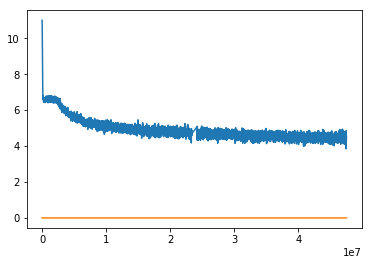

In [12]:
net2.model_fit(**net2.kwargs)
net2.show_report(**net2.kwargs)
net2.gen_graph(**net2.kwargs)
net2.save(**net2.kwargs)

Train Epoch: 0	Total_its: 0.00M [0.00M/24.17M]	Percdone: 0.00	Loss: 5.0137	Time: 0.01
Train Epoch: 0	Total_its: 1.17M [1.17M/24.17M]	Percdone: 0.05	Loss: 4.6017	Time: 0.56
Train Epoch: 0	Total_its: 2.35M [2.35M/24.17M]	Percdone: 0.10	Loss: 4.5509	Time: 1.12
Train Epoch: 0	Total_its: 3.52M [3.52M/24.17M]	Percdone: 0.15	Loss: 4.6704	Time: 1.67
Train Epoch: 0	Total_its: 4.68M [4.68M/24.17M]	Percdone: 0.19	Loss: 4.5119	Time: 2.22
Train Epoch: 0	Total_its: 5.87M [5.87M/24.17M]	Percdone: 0.24	Loss: 4.6975	Time: 2.79
Train Epoch: 0	Total_its: 7.07M [7.07M/24.17M]	Percdone: 0.29	Loss: 4.8490	Time: 3.36
Train Epoch: 0	Total_its: 8.26M [8.26M/24.17M]	Percdone: 0.34	Loss: 4.3756	Time: 3.92
Train Epoch: 0	Total_its: 9.45M [9.45M/24.17M]	Percdone: 0.39	Loss: 4.3605	Time: 4.49
Train Epoch: 0	Total_its: 10.63M [10.63M/24.17M]	Percdone: 0.44	Loss: 4.5596	Time: 5.06
Train Epoch: 0	Total_its: 11.82M [11.82M/24.17M]	Percdone: 0.49	Loss: 4.4730	Time: 5.62
Train Epoch: 0	Total_its: 13.01M [13.01M/24.17M]	P

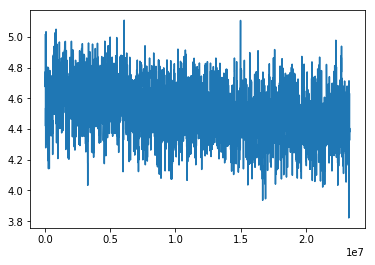

In [16]:
net2.model_fit(**net2.kwargs)
net2.show_report(**net2.kwargs)
net2.gen_graph(**net2.kwargs)
net2.save(**net2.kwargs)

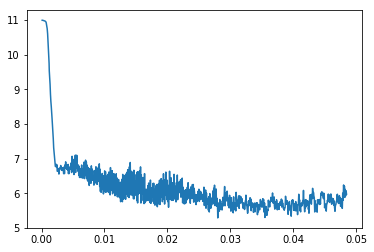

The end! 1.23 minutes


In [37]:
#scratch
net2.lr_finder(start_lr=1e-5,end_lr=.05)

In [15]:
net2.load('testing_unf',net2.kwargs['PATH'])

In [ ]:
net2.load('testing',net2.kwargs['PATH'])
net2.lr_finder(start_lr=.00001,end_lr=.002)

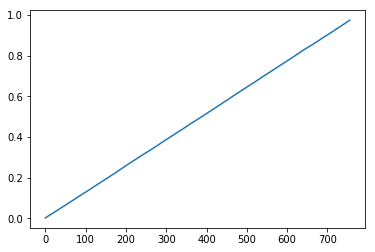

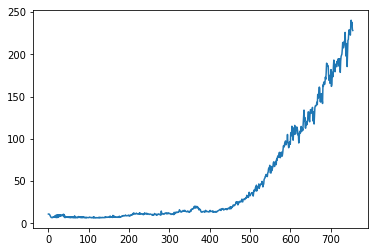

0.0018018527225682525 0.9739291087348602


In [79]:
lr_finder_loss_list=net2.lr_finder_loss_list
b_lr_list,losslist=zip(*lr_finder_loss_list)
plt.plot(b_lr_list)
plt.show()
plt.plot(losslist)
plt.show()
print(min(b_lr_list),max(b_lr_list))

In [43]:
net2.howdwegethere

'scratch -> tes -> test2'

In [14]:


epochs=2
starttime=time.time()
train_loss_list=[]
for epoch in range(1, epochs):
    pbar=0#progressbar
    for batch_idx, (data, target) in enumerate(trn_dl):
        #data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()#this actually updates the weights!
        pbar+=len(data)*bs
        train_loss_list.append([epoch,pbar,loss.data[0]])
        if batch_idx % 700 == 0:
            elapsed_time=time.time()-starttime
            print('Train Epoch: {} [{:.2f}M/{:.2f}M]\tPercdone: {:.2f}\tLoss: {:.4f}\tTime: {:.2f}'.format(
                    epoch, pbar/1000000, samp_n/1000000, pbar/samp_n,
                            loss.data[0], elapsed_time/60))
    val_loss=torch.Tensor().cuda()
    val_acc=[]
    for batch_idx, (data, target) in enumerate(val_dl):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        preds = torch.max(output, dim=1)[1]
        val_loss=torch.cat((val_loss,loss.data),0)
        val_acc.append(torch.eq(preds.data,target.data).float().mean())
    print('Validation Loss: {:.4f}\tAcc: {:.4f}\tPerp: {:.4f}'.format(
        val_loss.mean(),np.mean(np.array(val_acc)),np.exp(val_loss.mean())))
print('The end! {:.2f} minutes'.format((time.time()-starttime)/60))


Train Epoch: 1 [0.00M/24.17M]	Percdone: 0.00	Loss: 4.9046	Time: 0.00
Train Epoch: 1 [2.35M/24.17M]	Percdone: 0.10	Loss: 4.1845	Time: 1.01
Train Epoch: 1 [4.71M/24.17M]	Percdone: 0.20	Loss: 4.6796	Time: 2.02
Train Epoch: 1 [7.09M/24.17M]	Percdone: 0.29	Loss: 4.6089	Time: 3.04
Train Epoch: 1 [9.44M/24.17M]	Percdone: 0.39	Loss: 4.2952	Time: 4.05
Train Epoch: 1 [11.83M/24.17M]	Percdone: 0.49	Loss: 4.6392	Time: 5.08
Train Epoch: 1 [14.21M/24.17M]	Percdone: 0.59	Loss: 4.3743	Time: 6.11
Train Epoch: 1 [16.59M/24.17M]	Percdone: 0.69	Loss: 4.4841	Time: 7.13
Train Epoch: 1 [18.95M/24.17M]	Percdone: 0.78	Loss: 4.6725	Time: 8.15
Train Epoch: 1 [21.32M/24.17M]	Percdone: 0.88	Loss: 4.2527	Time: 9.18
Validation Loss: 4.4825	Acc: 0.2844	Perp: 88.4537
The end! 10.62 minutes


In [20]:
filename='3cyc_emb-frz_adam1e3_loss4p5_XXXX'

In [13]:
torch.save(net.state_dict(), PATH/'3cyc_emb-frz_adam1e3_loss4p5')

In [14]:
net.load_state_dict(torch.load(PATH/'2cyc_emb-frz_adam1e3', map_location=lambda storage, loc: storage))

AttributeError: 'dwb_model' object has no attribute 'load_state_dict'

In [16]:
#load dictionary
itos = pickle.load(open(PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [29]:
# generate some new text from the LM, to see how good it is
orig_bs=bs#save original bs, because we're changing it to 1 momentarily. We'll change it back once we're done here
net2.kwargs['bs']=1
#net2.hidden=(net2.one_hidden(), net2.one_hidden()) # reset model hidden state
net2.model.hidden=(net2.model.one_hidden(), net2.model.one_hidden()) # reset model hidden state
ss="""what i think """
tok = Tokenizer().spacy_tok(ss)#create a list of the tokens
print(' '.join(tok))
t=[stoi[tok[i]] for i in range(len(tok))]
t=Variable(torch.LongTensor(t).cuda()).view(-1,1)
#print(t)
for i in range(20):
    pred=net2.model(t)
    next_one=torch.topk(pred[-1],5)[1][np.random.randint(0,4)]
    t=Variable(torch.cat((t.data,next_one.data),0))
#print(t)
tnump=np.concatenate(t.data.cpu().numpy())
print(' '.join([itos[tnump[i]] for i in range(len(tnump))]))
net2.kwargs['bs']=orig_bs

what i think
what i think that you can be blocked for your time , i 'll be a good place , as you are trying


In [30]:
print(tnump)
#[itos[t.data[i].cpu().numpy()[0]] for i in range]
' '.join([itos[tnump[i]] for i in range(len(tnump))])

[ 61   8  90  18  13  57  30 216  23  41 112   4   8 188  30  11 127 230   4  33  13  34 294]


"what i think that you can be blocked for your time , i 'll be a good place , as you are trying"

0